# *1로부터의 개선사항*
- 구간을 40-49, 50-59, 60-69, 세 그룹으로 처치집단을 나눔
- X의 categorical feature 처리
- Y에 정신건강, 삶의 만족도, 경제적 만족도 추가 

# IMF 외환위기 트라우마 분석  - 개요

본 주피터 노트북에선 IMF 외환위기 당시 퇴직자이냐 아니냐가 추후의 소비 및 투자 성향에 어떠한 영향을 미치는지 알아본다.

실험은 아래와 같은 네 단계 절차로 진행 된다:
1. IMF 당시 정년이었던 사람, 그리고 정년이 아니었던 사람으로 그룹을 나눈다. 
2. 통제 변수 X와 추정값 Y를 찾는다. 
3. Linear Regression을 돌린다.
4. Causal Forest를 돌린다.

# 0. 데이터 불러오기

In [1]:
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML
from xgboost import XGBRegressor


# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from xgboost import XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
import statsmodels.api as sm
from scipy.stats import norm

# Explainability Libraries
import shap

# Model storage libraries
import joblib

# Optional: If you need to install xgboost within the notebook
# !pip install xgboost


In [2]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1.  그룹 나누기

우리의 가설은 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람이 소비 및 투자 습관에서 차이가 유의미한 차이가 있다는 것"이다. 이를 분석하기 위해서 IMF 당시 퇴직자와 비퇴직자 두 그룹으로 나눠야 한다.

**첫째로,**  노인실태조사에 퇴직 연령은 명시되지 않았기 때문에 확실히 집단을 나눌 수는 없다. 그래서 우리는 정년, 그리고 당시 정리해고/권고사직 평균연령을 기준으로 잡는다.

- IMF 외환위기 당시 국가가 지정한 정년은 만 60세이다 (지금도 동일).
- 한국 노동연구원에 따르면 IMF 외환위기 당시 정리해고/권고사직 평균연령은 약 50세이다. [기사](https://www.labortoday.co.kr/news/articleView.html?idxno=39838)

60세와 50세, 이 두가지 구분선을 취했다.

**둘째로,** 어떻게 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람" 이 두가지로 나눌 수 있는지 살펴본다.

대한민국의 관리체제 기간은 1997년 12월 3일부터 2001년 8월 23일까지 약 3년 8개월이었다. 고로 아래와 같은 세 집단으로 나눌 수 있다:

- 첫번째 집단은 97년 당시 (관리체제 시작) 40-49세였던 집단이다. 2001년 기준 43-52세, 2020년 기준 63-72세인 집단이다 (+23). <데이터는 65세 부터 시작>
- 두번째 집단은 97년 당시 (관리체제 종료) 50-59세였던 집단이다. 2001년 기준 53-62세, 2020년 기준 73-82세인 집단이다 (+23).
- 세번째 집단은 97년 당시 (관리체제 시작) 60-69세였던 집단이다. 2001년 기준 63-72세, 2020년 기준 83-92세인 집단이다 (+23).

데이터프레임 df에 칼럼 'treatment'를 추가한다. 넷 중 하나의 값을 가진다:
- forty: 40-49
- fifty: 50-59
- sixty: 60-69 
- rest: 그 외 데이터

In [4]:
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 92)
]
values = ["forty", "fifty", "sixty"]
df['treatment'] = np.select(conditions, values, default="rest")
df = df[df['treatment'] != "rest"]

데이터의 양과 Treatment의 분포를 살펴보았다.

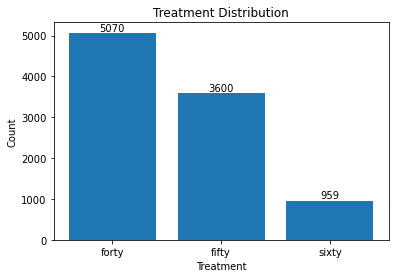

In [5]:
# Count the occurrences of each treatment
treatment_counts = df['treatment'].value_counts()

# Create a bar chart
plt.bar(treatment_counts.index, treatment_counts.values)

# Add counts on top of the bars
for i, count in enumerate(treatment_counts.values):
    plt.text(i, count + 0.2, str(count), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.title('Treatment Distribution')

# Show the plot
plt.show()

60세 이상의 데이터가 상대적으로 적은 감이 있지만, 일단 돌려본다.

# 2. 통제 변수 X와 Y 찾기

Linear Regression과 Causal Forest를 위해 통제변수 X와 Y를 살펴본다. (파일럿 분석인지라 X와 Y의 선정 둘 다 다소 간헐적임은 감안해주시길 바랍니다)

일단 X를 살펴본다.
- 건강: B1 (1->5 안 좋아짐)*(비해당:9)*
- 성별: RES_SEX <남자: 1, 여자: 2> -> categorical
- 교육수준: RES_EDU1 <1->7 높아짐>
-  지역 (광역시/도): AREA -> categortical
    - <11:서울 21:부산 22:대구 23:인천 24:광주 25:대전 26:울산 29:세종 31:경기 32:강원 33:충북 34:충남 35:전북 36:전남 37:경북 38:경남 39:제주>
- 지역: EDM 동부/읍면부 (1:동부 0:읍면부)
- 본인 총수입액 금액: J3b_1_13 
- 나이: RES_AGE
- 인지기능: I1x1 *(결측치:99)*

그 다음 Y를 살펴본다
- 부동산자산비중(1 - 금융자산비중): property_equity_ratio
- 문화여가비비중: leisure_expense_ratio (월평균 여가비 소비/월평균 소비지출액)
- 우울증척도총점: B6_SUM
- 만족도_경제상태: H16_2 (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)
- 만족도_삶 전반: H16_7  (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)

In [6]:
df['leisure_expense_ratio'] = df['J1b_3']/ df['J4']

일단 CI를 그려본다. 변인 통제가 안 되어있다는 점은 감안 할 필요가 있다.

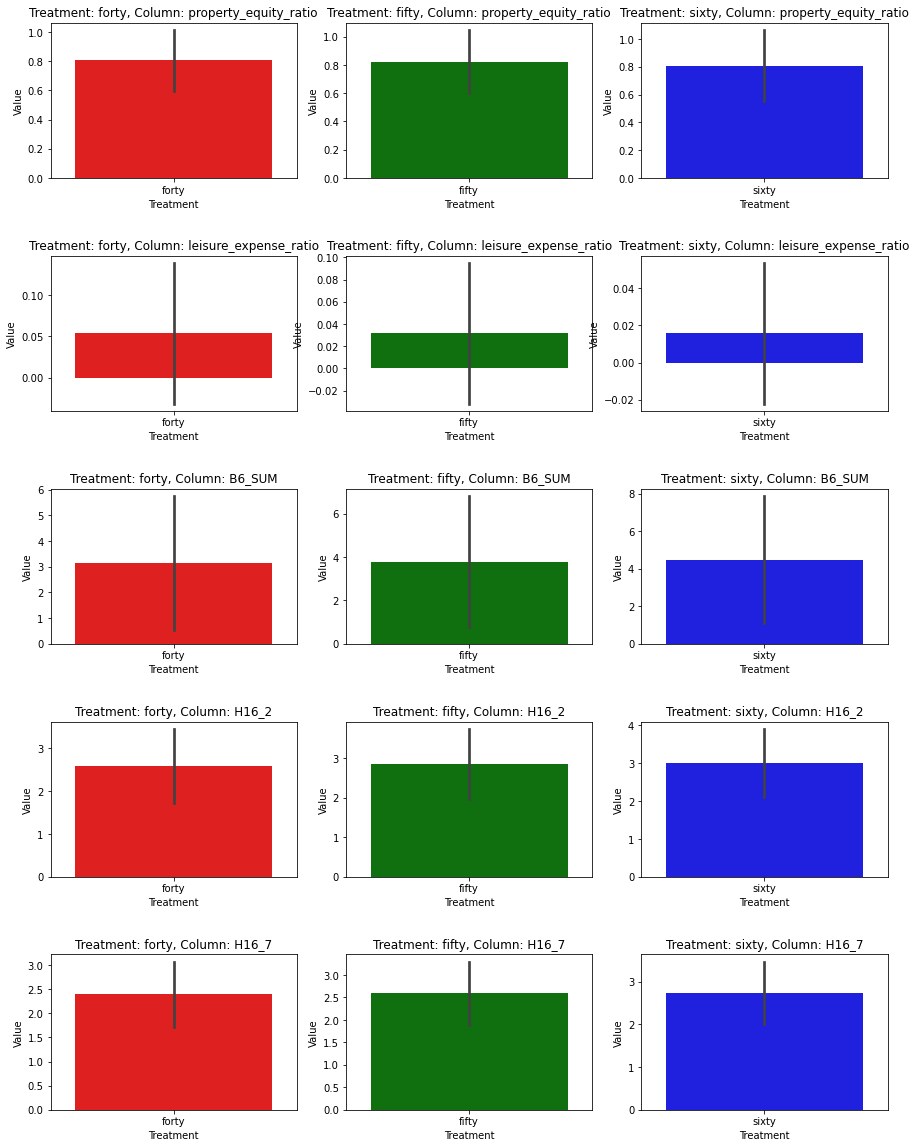

In [7]:
columns_to_plot = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']
treatments = ['forty','fifty','sixty']
colors = {'forty': 'red', 'fifty': 'green', 'sixty': 'blue'}

fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_plot):
    for j, treatment in enumerate(treatments):
        sns.barplot(x='treatment', y=column, data=df[df['treatment'] == treatment], ci="sd", color=colors[treatment], ax=axes[i,j])
        axes[i,j].set_title(f'Treatment: {treatment}, Column: {column}')
        axes[i,j].set_ylabel('Value')
        axes[i,j].set_xlabel('Treatment')

plt.show()

# 3. Linear Regression

그 다음으론 linear regression을 돌린다.

Summary for property_equity_ratio:
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.057
Model:                               OLS   Adj. R-squared:                  0.054
Method:                    Least Squares   F-statistic:                     23.19
Date:                   Fri, 11 Aug 2023   Prob (F-statistic):          4.68e-103
Time:                           14:52:53   Log-Likelihood:                 1224.0
No. Observations:                   9629   AIC:                            -2396.
Df Residuals:                       9603   BIC:                            -2210.
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

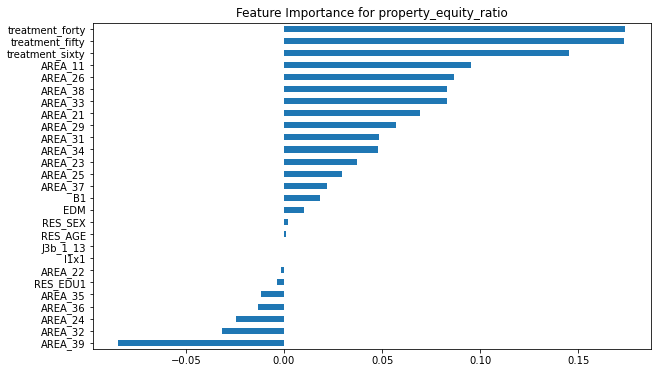

Summary for leisure_expense_ratio:
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.158
Model:                               OLS   Adj. R-squared:                  0.156
Method:                    Least Squares   F-statistic:                     72.15
Date:                   Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                           14:52:53   Log-Likelihood:                 12023.
No. Observations:                   9629   AIC:                        -2.399e+04
Df Residuals:                       9603   BIC:                        -2.381e+04
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

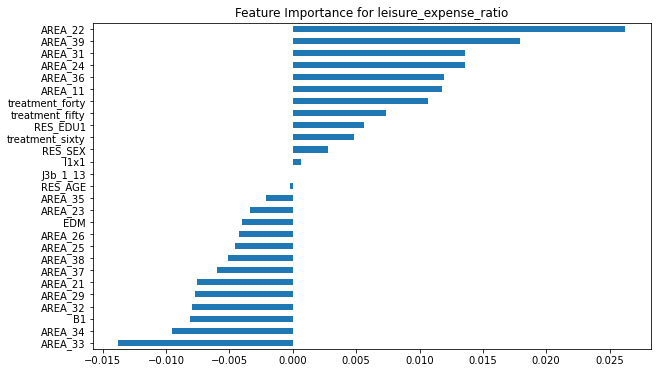

Summary for B6_SUM:
                            OLS Regression Results                            
Dep. Variable:                 B6_SUM   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     114.6
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:52:53   Log-Likelihood:                -22608.
No. Observations:                9629   AIC:                         4.527e+04
Df Residuals:                    9603   BIC:                         4.545e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.

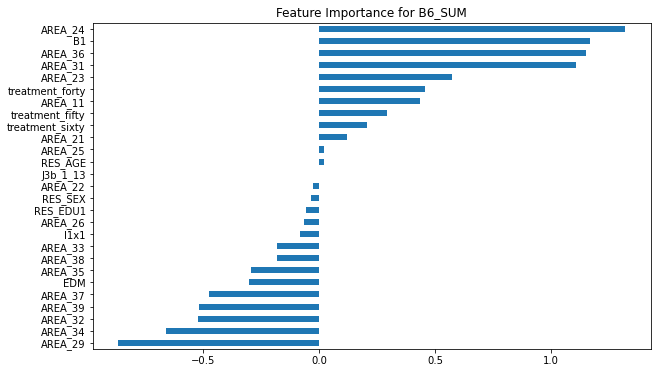

Summary for H16_2:
                            OLS Regression Results                            
Dep. Variable:                  H16_2   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     120.0
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:52:54   Log-Likelihood:                -11233.
No. Observations:                9629   AIC:                         2.252e+04
Df Residuals:                    9603   BIC:                         2.270e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7

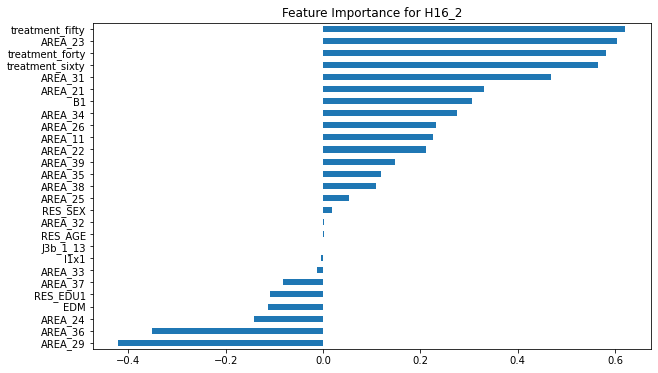

Summary for H16_7:
                            OLS Regression Results                            
Dep. Variable:                  H16_7   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     108.5
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:52:54   Log-Likelihood:                -8988.3
No. Observations:                9629   AIC:                         1.803e+04
Df Residuals:                    9603   BIC:                         1.822e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8

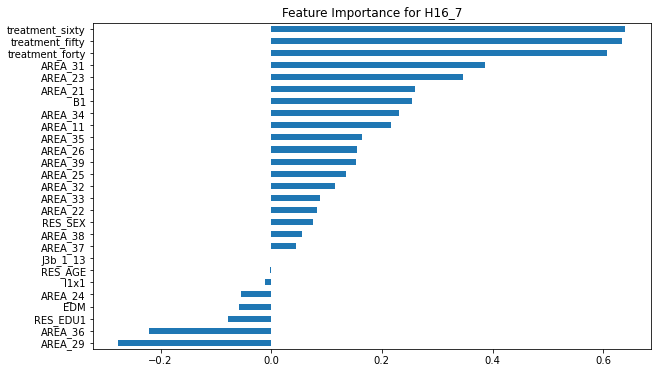

In [8]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
X_columns = ['treatment','B1','RES_SEX','RES_EDU1','AREA','EDM','J3b_1_13','RES_AGE','I1x1']
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

# Convert categorical variables to one-hot encoded format
X = pd.get_dummies(df[X_columns], columns=['treatment', 'AREA'], drop_first=False)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

for y_column in Y_options:
    Y = df[y_column]

    # Fit the OLS model
    model = sm.OLS(Y, X).fit()

    # Print the summary
    print(f"Summary for {y_column}:")
    print(model.summary())
    print("11:서울 21:부산 22:대구 23:인천 24:광주 25:대전 26:울산 29:세종 31:경기 32:강원 33:충북 34:충남 35:전북 36:전남 37:경북 38:경남 39:제주")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance = model.params.drop('const')
    feature_importance.sort_values().plot(kind='barh')
    plt.title(f"Feature Importance for {y_column}")
    plt.show()


# 4. Robustness Check

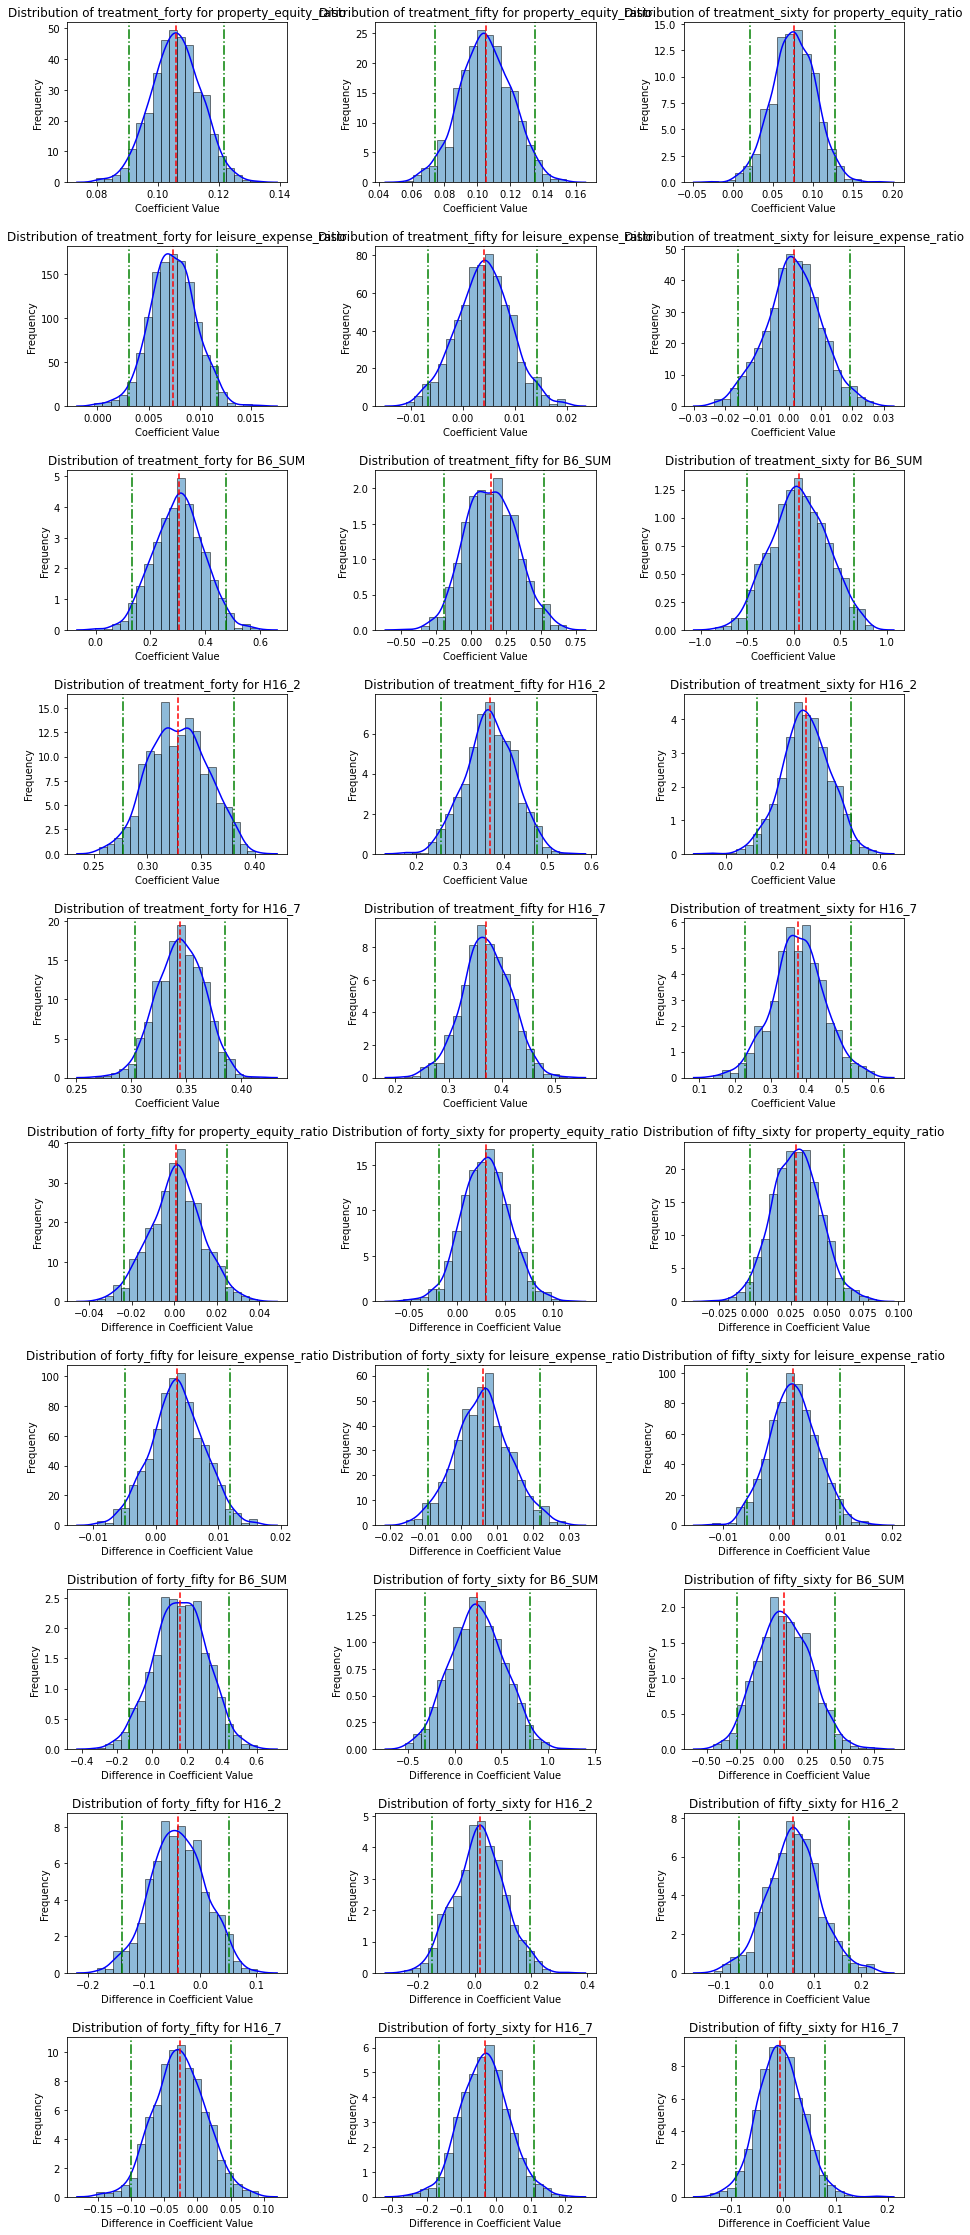

In [8]:
# List of dependent variables
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

# Independent variables
X_columns = ['treatment','B1','RES_SEX','RES_EDU1','AREA','EDM','J3b_1_13','RES_AGE','I1x1']

# Convert categorical variables to one-hot encoded format
X = pd.get_dummies(df[X_columns], columns=['treatment', 'RES_SEX', 'AREA', 'EDM'], drop_first=False)

# Treatment dummies
treatment_dummies = ['treatment_forty', 'treatment_fifty', 'treatment_sixty']

# Initialize the storage for feature importance and differences
treatment_importance = {y: {dummy: [] for dummy in treatment_dummies} for y in Y_options}
for y in Y_options:
    treatment_importance[y]['forty_fifty'] = []
    treatment_importance[y]['forty_sixty'] = []
    treatment_importance[y]['fifty_sixty'] = []

# Run 100 regressions for each dependent variable
for y in Y_options:
    for i in range(1000):
        # Random sample
        sample_index = np.random.choice(df.index, size=len(df)//3, replace=False)
        X_sample = X.loc[sample_index]
        y_sample = df[y].loc[sample_index]

        # Fit the model
        X_const = sm.add_constant(X_sample)
        model = sm.OLS(y_sample, X_const).fit()

        # Record the coefficients of treatment dummies
        for dummy in treatment_dummies:
            treatment_importance[y][dummy].append(model.params[dummy])
        
        # Record the differences
        treatment_values = {dummy: model.params[dummy] for dummy in treatment_dummies}
        treatment_importance[y]['forty_fifty'].append(treatment_values['treatment_forty'] - treatment_values['treatment_fifty'])
        treatment_importance[y]['forty_sixty'].append(treatment_values['treatment_forty'] - treatment_values['treatment_sixty'])
        treatment_importance[y]['fifty_sixty'].append(treatment_values['treatment_fifty'] - treatment_values['treatment_sixty'])

# Set up the 10x3 grid
fig, axs = plt.subplots(10, 3, figsize=(15, 40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot the distribution of feature importance for treatment dummies
for row, y in enumerate(Y_options):
    for col, dummy in enumerate(treatment_dummies):
        data = treatment_importance[y][dummy]

        # Plot histogram
        axs[row, col].hist(data, bins=20, density=True, edgecolor='black', alpha=0.5)

        # Plot KDE (smooth curve)
        sns.kdeplot(data, ax=axs[row, col], color='blue')

        # Plot mean vertical line
        mean_value = np.mean(data)
        axs[row, col].axvline(x=mean_value, color='r', linestyle='--')

        # Plot 95% CI boundary
        ci_lower, ci_upper = np.percentile(data, [2.5, 97.5])
        axs[row, col].axvline(x=ci_lower, color='g', linestyle='-.')
        axs[row, col].axvline(x=ci_upper, color='g', linestyle='-.')

        axs[row, col].set_title(f'Distribution of {dummy} for {y}')
        axs[row, col].set_xlabel('Coefficient Value')
        axs[row, col].set_ylabel('Frequency')

# Plot the distributions of differences
difference_labels = ['forty_fifty', 'forty_sixty', 'fifty_sixty']
for row, y in enumerate(Y_options):
    for col, diff_label in enumerate(difference_labels):
        data = treatment_importance[y][diff_label]
        row_index = row + 5  # Adjust the row index to start from the 6th row

        # Plot histogram
        axs[row_index, col].hist(data, bins=20, density=True, edgecolor='black', alpha=0.5)

        # Plot KDE (smooth curve)
        sns.kdeplot(data, ax=axs[row_index, col], color='blue')

        # Plot mean vertical line
        mean_value = np.mean(data)
        axs[row_index, col].axvline(x=mean_value, color='r', linestyle='--')

        # Plot 95% CI boundary
        ci_lower, ci_upper = np.percentile(data, [2.5, 97.5])
        axs[row_index, col].axvline(x=ci_lower, color='g', linestyle='-.')
        axs[row_index, col].axvline(x=ci_upper, color='g', linestyle='-.')

        axs[row_index, col].set_title(f'Distribution of {diff_label} for {y}')
        axs[row_index, col].set_xlabel('Difference in Coefficient Value')
        axs[row_index, col].set_ylabel('Frequency')

plt.show()


In [9]:
# Create a dictionary to store the average values of feature importance differences
average_differences = {'Dependent Variable': [], 'forty_fifty': [], 'forty_sixty': [], 'fifty_sixty': []}

# Calculate the average values for each dependent variable and each difference category
for y in Y_options:
    average_differences['Dependent Variable'].append(y)
    for diff_label in difference_labels:
        average_differences[diff_label].append(np.mean(treatment_importance[y][diff_label]))

# Convert the dictionary to a Pandas DataFrame
average_differences_df = pd.DataFrame(average_differences)

# Display the DataFrame
average_differences_df

,Dependent Variable,forty_fifty,forty_sixty,fifty_sixty
0,property_equity_ratio,0.000925,0.029670,0.028744
1,leisure_expense_ratio,0.003414,0.005886,0.002472
2,B6_SUM,0.161154,0.241392,0.080238
3,H16_2,-0.039240,0.016963,0.056203
4,H16_7,-0.026407,-0.032364,-0.005958


# 4.  Causal Forest

Linear Regression으론 TE가 잘 잡히지 않았다. 고로 이번에는 Causal Forest를 확인해본다.

Observational data를 잘 처리하는 CausalForestDML을 사용한다. DML, 즉 double machine learning의 수식은 아래와 같다:

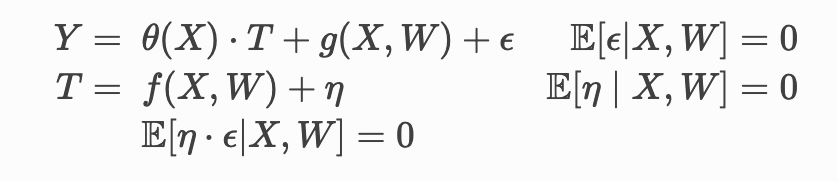

In [13]:
from IPython.display import Image
Image(filename='images/dml.png')

Y는 outcome이고 T는 treatment이다.

X와 W를 집고 넘어가야한다:
- T는 X와 W 두 값에 대해 고루 영향을 받는다.
- Y중 g, 즉 처치효과를 제외한 부분의 값은 X와 W 두 값에 대해 결과값을 얻는다. 
- theta, 즉 이질적 treatment effect는 X에 대해서만 영향을 받는다. 

즉, X는 heterogeneity를 야기하는 feature들이고, W는 이를 제외한 모든 control feature들의 값이다.

Causal forest는 처치효과의 이질성을 구하기 위한 기법이다. 하지만 그 전에 처치효과 자체를 정교하게 구해주기도 한다. 그래서 일단 causal forest를 돌려 처치효과와 이질적 처치효과를 모두 확인해본다. 

Running analysis of property_equity_ratio excluding treatment group: forty


invalid value encountered in sqrt
100%|===================| 4542/4559 [05:16<00:01]        

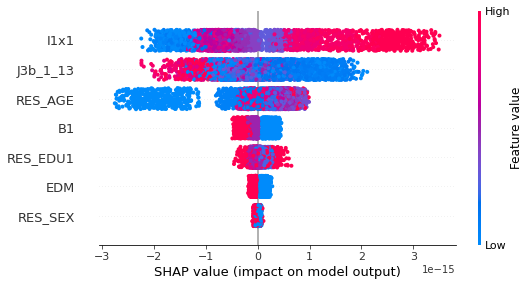

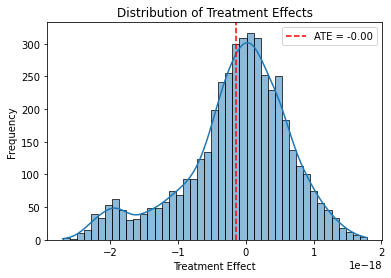

Running analysis of property_equity_ratio excluding treatment group: fifty


100%|===================| 6023/6029 [02:49<00:00]        

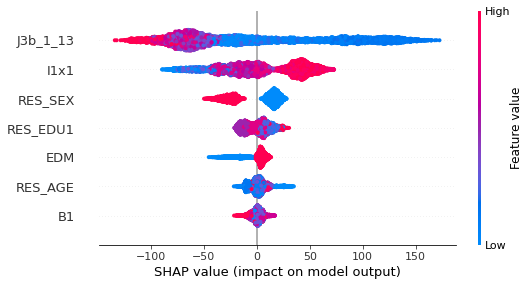

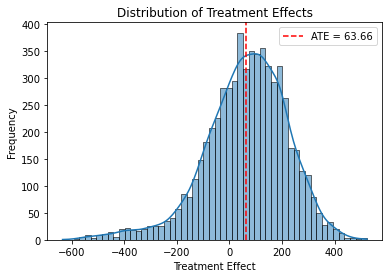

Running analysis of property_equity_ratio excluding treatment group: sixty


100%|===================| 8635/8670 [32:32<00:07]        

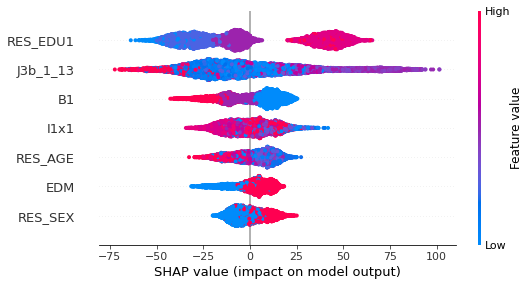

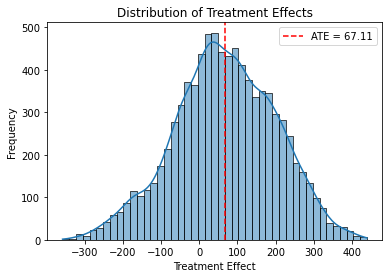

Running analysis of leisure_expense_ratio excluding treatment group: forty


invalid value encountered in sqrt
100%|===================| 4551/4559 [03:39<00:00]        

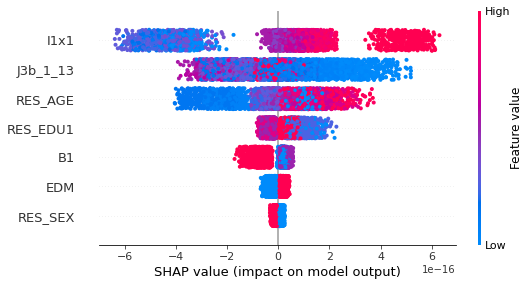

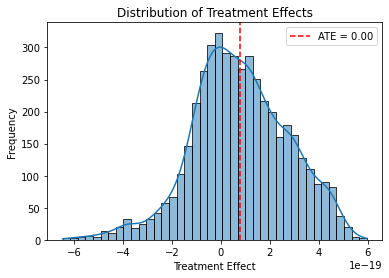

Running analysis of leisure_expense_ratio excluding treatment group: fifty


100%|===================| 6000/6029 [14:03<00:04]        

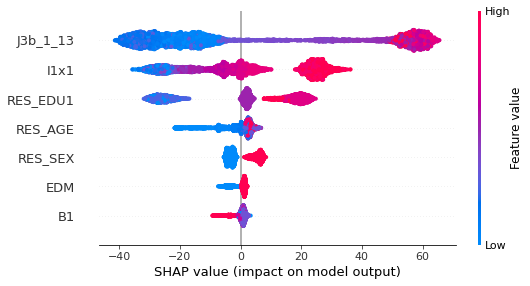

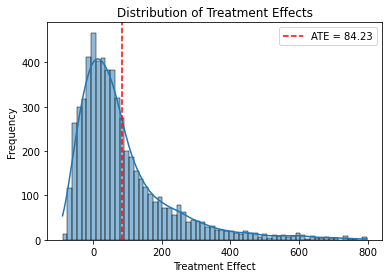

Running analysis of leisure_expense_ratio excluding treatment group: sixty


100%|===================| 8667/8670 [03:32<00:00]        

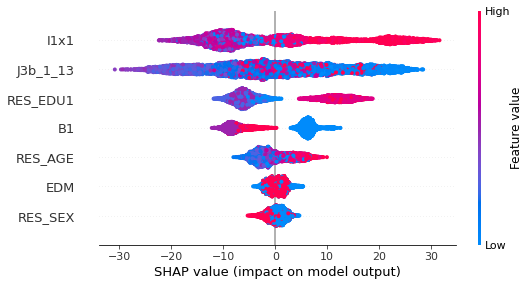

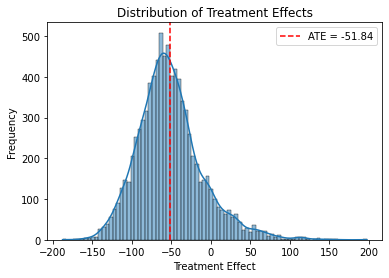

Running analysis of B6_SUM excluding treatment group: forty


invalid value encountered in sqrt
 98%|===================| 4473/4559 [00:35<00:00]        

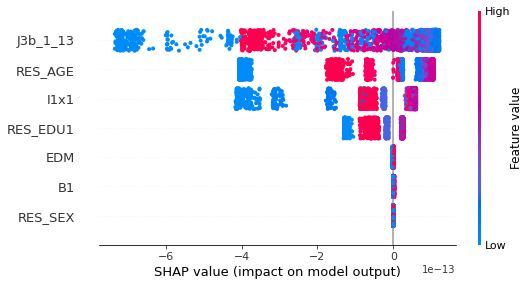

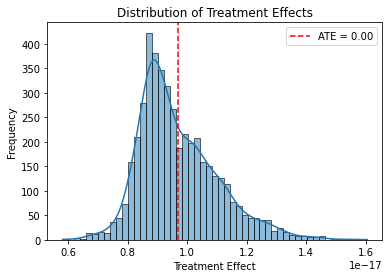

Running analysis of B6_SUM excluding treatment group: fifty


 99%|===================| 5993/6029 [02:16<00:00]        

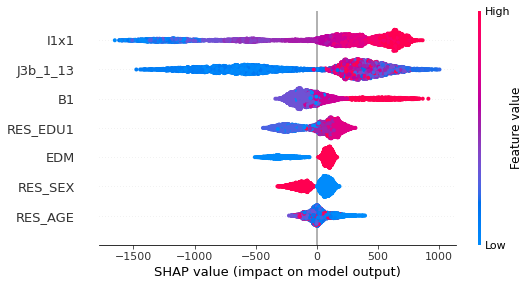

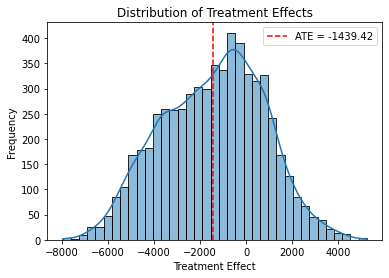

Running analysis of B6_SUM excluding treatment group: sixty


100%|===================| 8668/8670 [16:08<00:00]        

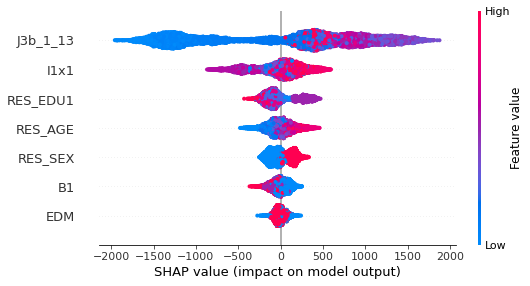

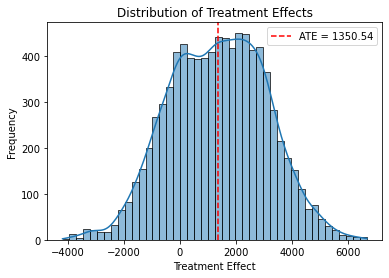

Running analysis of H16_2 excluding treatment group: forty


invalid value encountered in sqrt
100%|===================| 4554/4559 [21:04<00:01]        

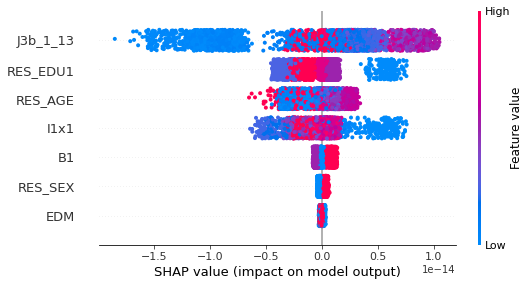

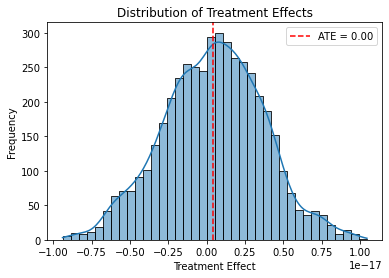

Running analysis of H16_2 excluding treatment group: fifty


 27%|=====               | 1645/6029 [02:29<06:37]       

In [ ]:
# Define some parameters
n_trees = 1000
min_leaf_size = 10
max_depth = 20
subsample_ratio = 0.2

for y_option in ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']:
    
    print("=============================================================================")
    print("=============================================================================")
    
    for treatment_group in ['forty', 'fifty', 'sixty']:
      
        print(f"Running analysis of {y_option} excluding treatment group: {treatment_group}")

        # Create a copy of the DataFrame excluding the specified treatment group
        subset_df = df[df['treatment'] != treatment_group]

        # Define the treatment variable, T, coding 'forty' as 1 and the other group as 0
        T = (subset_df['treatment'] == 'forty').astype(int).values

        # Define X and Y as before
        X = subset_df[['B1', 'RES_SEX', 'RES_EDU1', 'EDM', 'J3b_1_13', 'RES_AGE', 'I1x1']]
        Y = subset_df[y_option].values

        # Scale the features
        scaler = StandardScaler()

        # Define and fit the causal forest model
        est = CausalForestDML(model_y=XGBRegressor(),
                              model_t=XGBRegressor(),
                              n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                              max_samples=subsample_ratio/2,
                              random_state=123)
        est.fit(Y, T, X=X)

        # Get treatment effects and intervals
        treatment_effects = est.effect(X)
        te_lower, te_upper = est.effect_interval(X)

        # Obtain SHAP values (if the version of EconML supports it)
        shap_values = est.shap_values(X) if hasattr(est, 'shap_values') else "Not Available"

        # Beeswarm Plot
        shap.plots.beeswarm(shap_values['Y0']['T0'])
        
        # Calculate the Average Treatment Effect (ATE)
        ate = np.mean(treatment_effects)

        # Plotting the distribution of treatment effects
        sns.histplot(treatment_effects, kde=True)
        plt.axvline(x=ate, color='r', linestyle='--', label=f'ATE = {ate:.2f}') # Add vertical line at ATE
        plt.title('Distribution of Treatment Effects')
        plt.xlabel('Treatment Effect')
        plt.ylabel('Frequency')
        plt.legend() # Add legend to show the label for the ATE line
        plt.show()

